In [1]:
import os
if 'COLAB_RELEASE_TAG' in os.environ:
  from google.colab import userdata
  import pathlib
  pathlib.Path('client_secret.json').write_text(userdata.get('CLIENT_SECRET'))

  # Use `--no-browser` in colab
  !gcloud auth application-default login --no-browser --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'
else:
  !gcloud auth application-default login --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=286505368705-9ptq7mdfs7fanekq5pu7tq01ria69k4a.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.tuning&state=L8UXN8y5FzlZ7xtjQyToymM7DcbH0C&access_type=offline&code_challenge=Zbghd4S6Tb1D8hR0sIXXqwsJfmbeADNF8gH50enhvQ8&code_challenge_method=S256

Detected locale "C" with character encoding "ANSI_X3.4-1968", which is not UTF-8.
Qt depends on a UTF-8 locale, and has switched to "C.UTF-8" instead.
If this causes problems, reconfigure your locale. See the locale(1) manual
for more information.

Credentials saved to file: [/home/lintangbs/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).


In [2]:
!pip install -q google-generativeai


[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import google.generativeai as genai

In [4]:
for i, m in zip(range(5), genai.list_tuned_models()):
    print(m.name)

tunedModels/geminimedicalqaindo-4a7wh1ol2f7o
tunedModels/geminipromedicalqaindolintang-hzz2fbhyts
tunedModels/geminimedicalqaindobatch4lrm05-qwlfewbdx
tunedModels/gemini-welllahh-temperature-zero-975
tunedModels/gemini-welllahh-zerotemp-lrfv-3536


In [22]:
base_model = [
    m
    for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods
][1]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description='Fast and versatile multimodal model for scaling across diverse tasks',
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [24]:
import pandas as pd

dataset_fine_tune = pd.read_csv("gemini_fine_tune_dataset.csv")

In [25]:
dataset_fine_tune.head()

,Unnamed: 0,question,answer,dataset_name,system_prompt,Focus (Drug),Question Type,Section Title,URL,qtype
0,0,Literature on Cardiac amyloidosis. Please let...,Cardiac amyloidosis is a disorder caused by de...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Migraine seems to be a spectrum of conditions ...,There is no specific cure for migraine headach...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,DO I USE PYRIDOXINE TABLETS EVEN IF IM PREGNANT?,"Before taking pyridoxine, tell your doc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,i have lymphoma what causes cramp after chemo ...,Muscle cramps are common and often occur when ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,I wonder of new research and testing on macula...,These resources address the diagnosis or manag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
dataset_fine_tune = dataset_fine_tune.drop(
    [
        "Unnamed: 0",
        "dataset_name",
        "system_prompt",
        "Focus (Drug)",
        "Question Type",
        "Section Title",
        "URL",
        "qtype",
    ],
    axis=1,
)

In [27]:
dataset_fine_tune.head()

,question,answer
0,Literature on Cardiac amyloidosis. Please let...,Cardiac amyloidosis is a disorder caused by de...
1,Migraine seems to be a spectrum of conditions ...,There is no specific cure for migraine headach...
2,DO I USE PYRIDOXINE TABLETS EVEN IF IM PREGNANT?,"Before taking pyridoxine, tell your doc..."
3,i have lymphoma what causes cramp after chemo ...,Muscle cramps are common and often occur when ...
4,I wonder of new research and testing on macula...,These resources address the diagnosis or manag...


In [28]:
fine_tune_data = []

In [29]:
for index, row in dataset_fine_tune.iterrows():
    fine_tune_data.append({"text_input": row["question"], "output": row["answer"]})

In [30]:
fine_tune_data[:2]

[{'text_input': 'Literature on Cardiac amyloidosis.  Please let me know where I can get literature on Cardiac amyloidosis.  My uncle died yesterday from this disorder.  Since this is such a rare disorder, and to honor his memory, I would like to distribute literature at his funeral service.  I am a retired NIH employee, so I am familiar with the campus in case you have literature at NIH that I can come and pick up.  Thank you ',
  'output': 'Cardiac amyloidosis is a disorder caused by deposits of an abnormal protein (amyloid) in the heart tissue. These deposits make it hard for the heart to work properly.The term "amyloidosis" refers not to a single disease but to a collection of diseases in which a protein-based infiltrate deposits in tissues as beta-pleated sheets. The subtype of the disease is determined by which protein is depositing; although dozens of subtypes have been described, most are incredibly rare or of trivial importance. This analysis will focus on the main systemic for

In [31]:
len(fine_tune_data)

27471

In [40]:
import random

name = f"gemini-welllahh-batch16-lrone-{random.randint(0,10000)}"
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model="models/gemini-1.5-flash-001-tuning",
    training_data=fine_tune_data,
    id=name,
    epoch_count=5,
    batch_size=16,
    learning_rate=0.00001,
    temperature=0.0,
    # learning_rate_multiplier=0.1 # gakbisa
)

In [41]:
model = genai.get_tuned_model(f"tunedModels/{name}")

model

TunedModel(name='tunedModels/gemini-welllahh-batch16-lrone-5867',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=0.0,
           top_p=0.95,
           top_k=64,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2024, 10, 25, 10, 8, 10, 475788, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 10, 25, 10, 8, 10, 475788, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=None,
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=5,
                                                                  batch_size=16,
                                                                  learning_rate=1e-05)),
           reader_project_numbers

In [42]:
# tunedModels/gemini-welllahh-temperature-zero-975

In [5]:
model = genai.get_tuned_model(f"tunedModels/liveqamedgeminilintangbatch16-jkogvah5sz")

model

TunedModel(name='tunedModels/liveqamedgeminilintangbatch16-jkogvah5sz',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='liveqa-med-gemini-lintang-batch16',
           description=('{"description":"lm 0.1 learning rate, batch 16, liveqa '
                        'dataset","exampleInput":"question","exampleOutput":"answer","showedTuningComplete":false,"rowsCount":626}'),
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2024, 10, 26, 4, 14, 18, 251419, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 10, 26, 4, 38, 39, 235526, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 10, 26, 4, 15, 36, 880931, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2024, 10, 26, 4, 3

In [6]:
model.state

<State.ACTIVE: 2>

<Axes: xlabel='epoch', ylabel='mean_loss'>

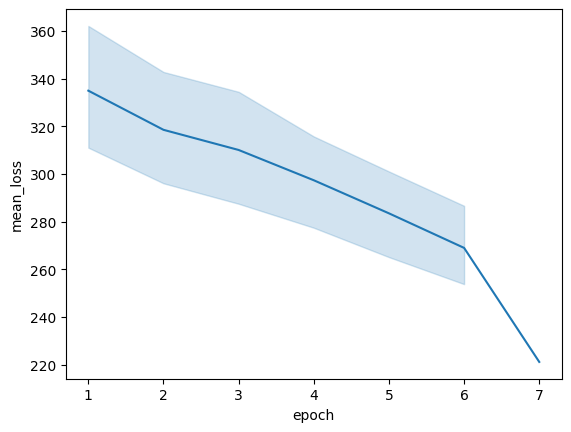

In [7]:
import pandas as pd
import seaborn as sns


snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x="epoch", y="mean_loss")

In [8]:
# wkwkwk idk
# coba ganti learning rate multiplier/tuning hyperparameter lainnya